In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

import util_functions as fs
import symbol_path_backup as pth
import imp
imp.reload(fs)
imp.reload(pth)

%matplotlib inline

In [11]:
#Read music sheets - Binary thresholding and resizing
sheets = fs.get_images('../data/You_to_me_me_to_you', resize_factor=1, denoise=False, threshold=200)

>>> Folder : ../data/You_to_me_me_to_you : 4 files
01 : ../data/You_to_me_me_to_you/p1.png : (1809, 1280)
02 : ../data/You_to_me_me_to_you/p2.png : (1809, 1280)
03 : ../data/You_to_me_me_to_you/p3.png : (1809, 1280)
04 : ../data/You_to_me_me_to_you/p4.png : (1809, 1280)
>>> Inverse binary thresholding with threshold value 200


In [12]:
sample_image = sheets[0]

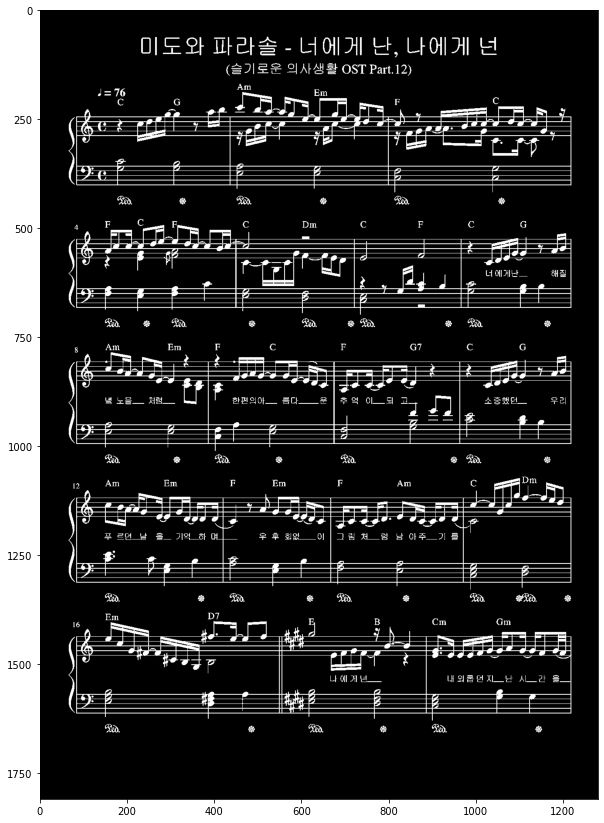

In [13]:
#Show sample
fs.plot_single_image(sample_image, off_axis=False)

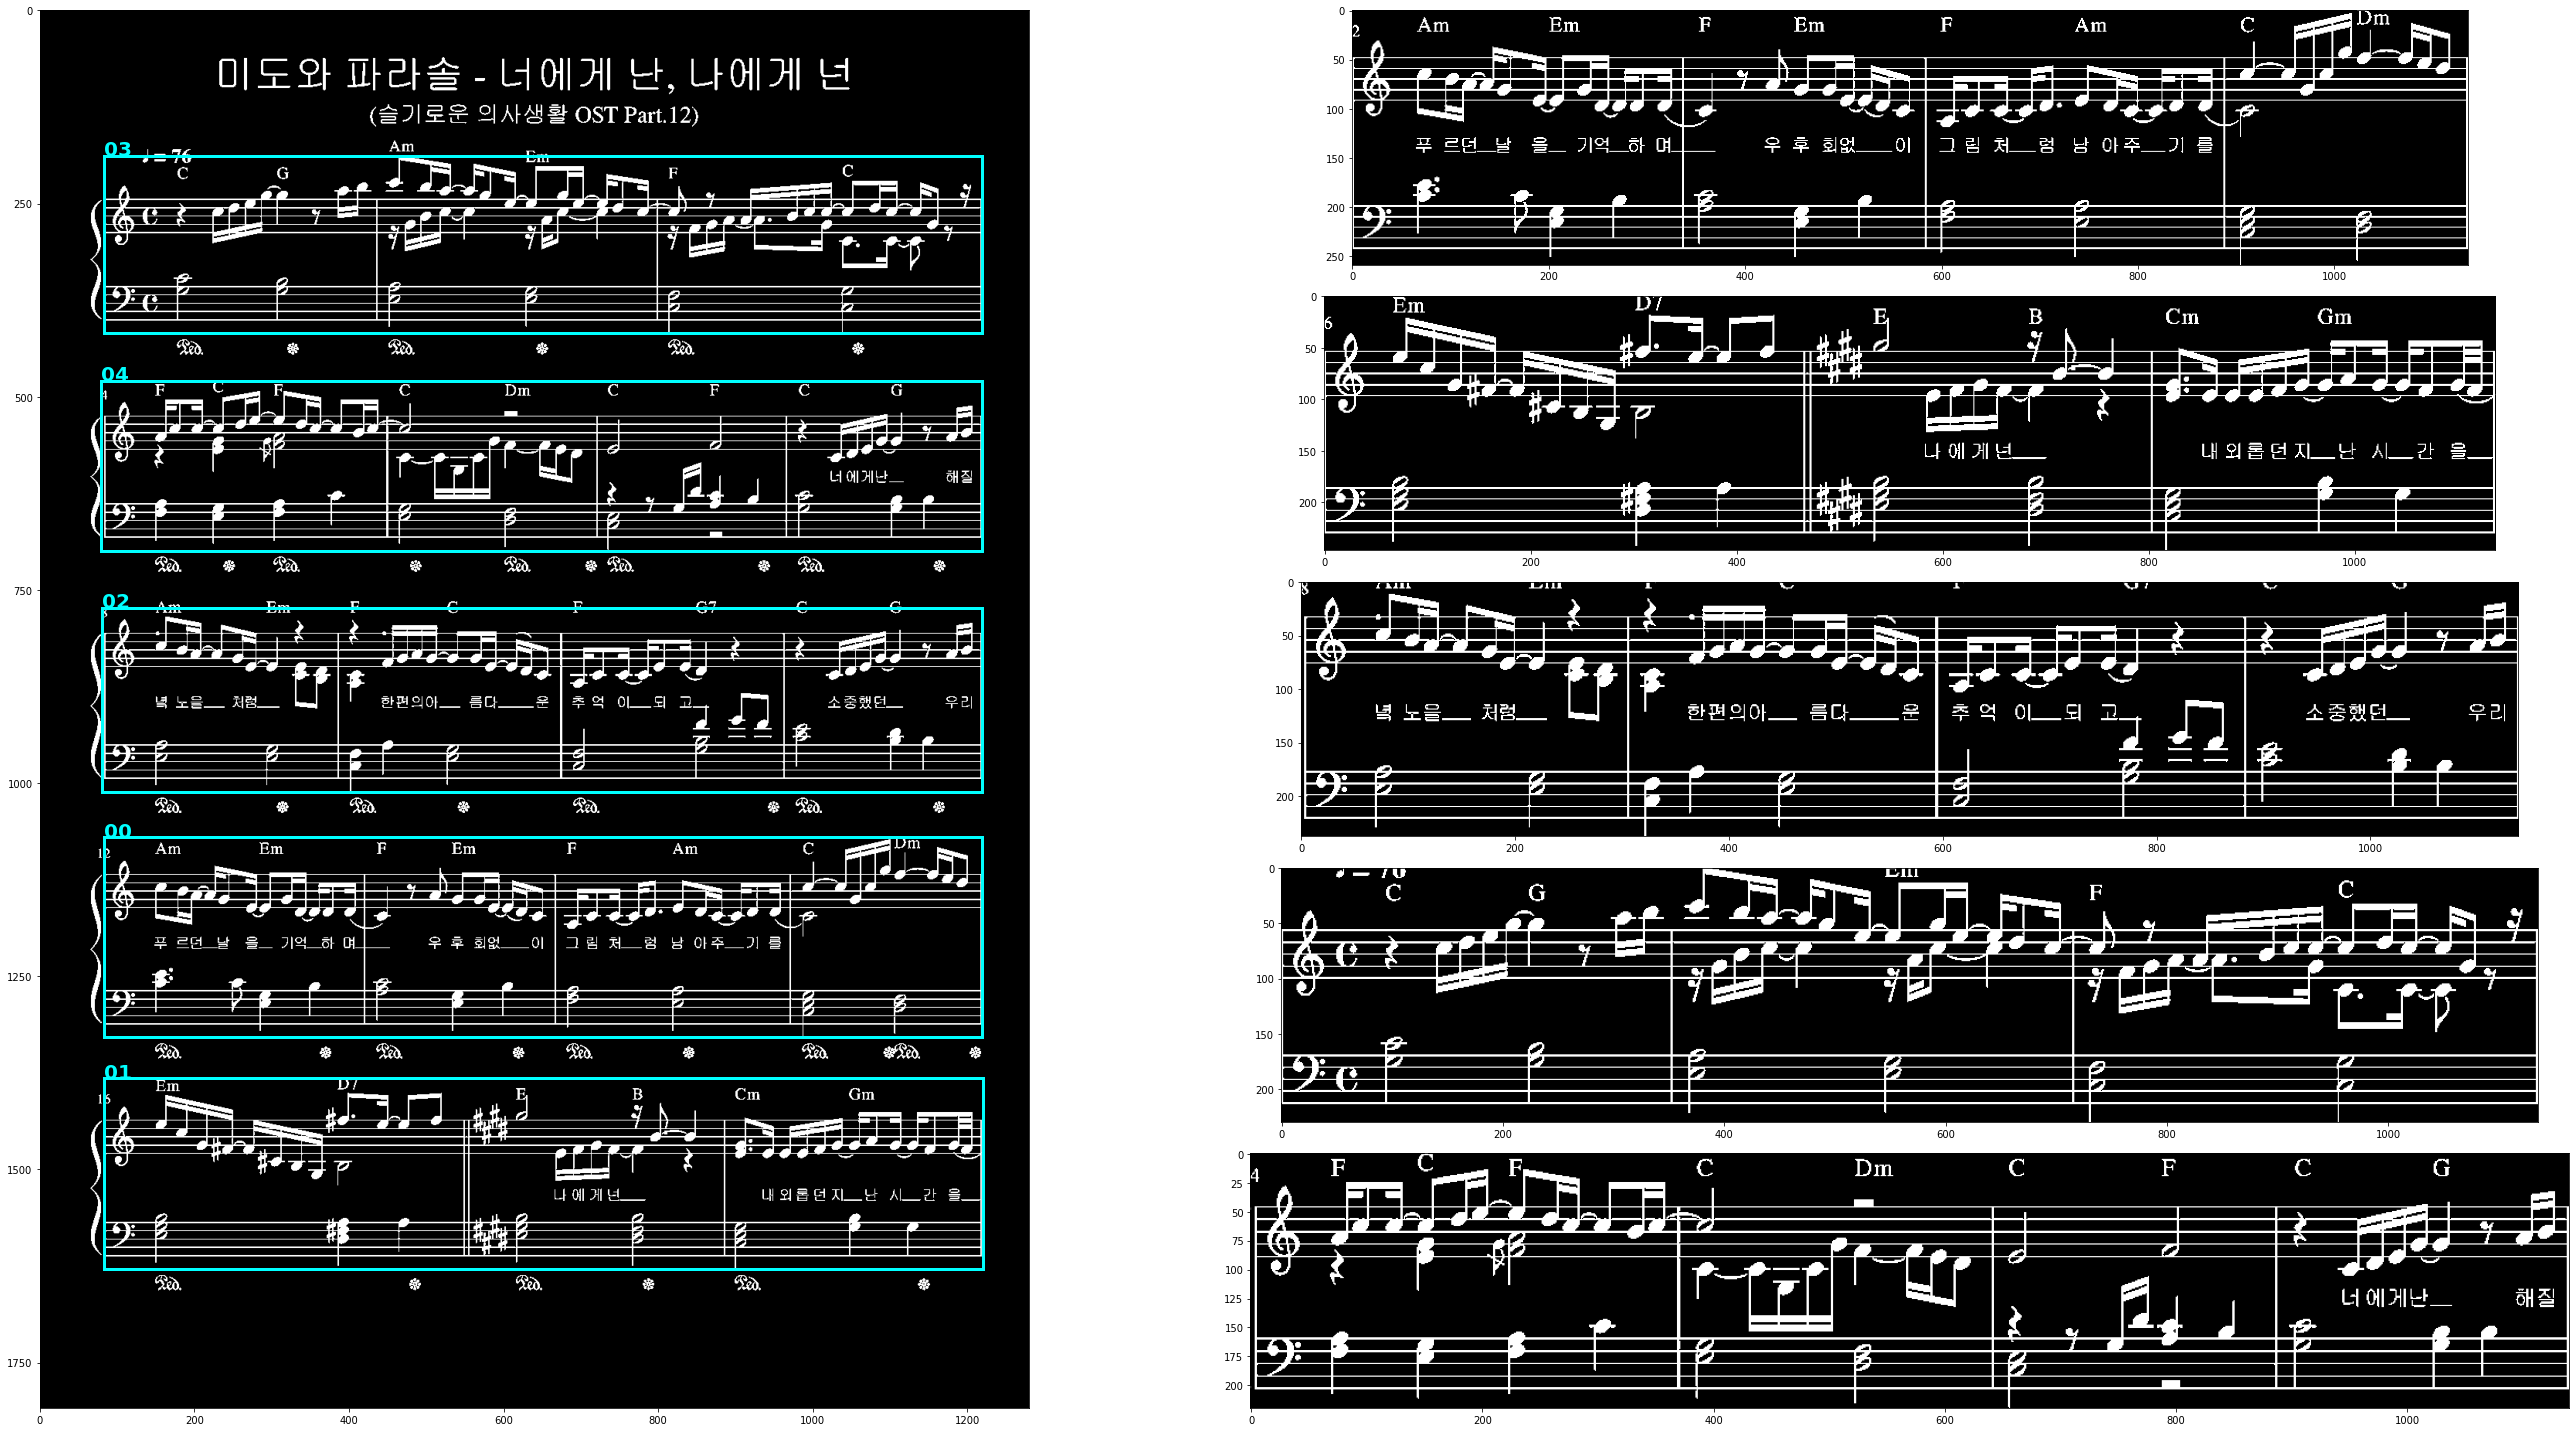

In [14]:
#Get main components of sheet
main_components, pos, _ = fs.get_main_components(sample_image)

#Show sample
import matplotlib.patches as patches

row = len(main_components)

fig = plt.figure(figsize=(40,20))
ax = plt.subplot2grid((row, 2), (0, 0), rowspan=row)
ax.imshow(sample_image, cmap='gray')
for i, (x, y, w, h, area) in enumerate(pos):  #Highlighting
    ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
    ax.text(x, y, f'{i:02d}', color='cyan', fontsize=20, fontweight='bold')

for i in range(len(main_components)):
    ax = plt.subplot2grid((row, 2), (i, 1))
    ax.imshow(main_components[i], cmap='gray')


fig.set_tight_layout(True)
plt.show() 

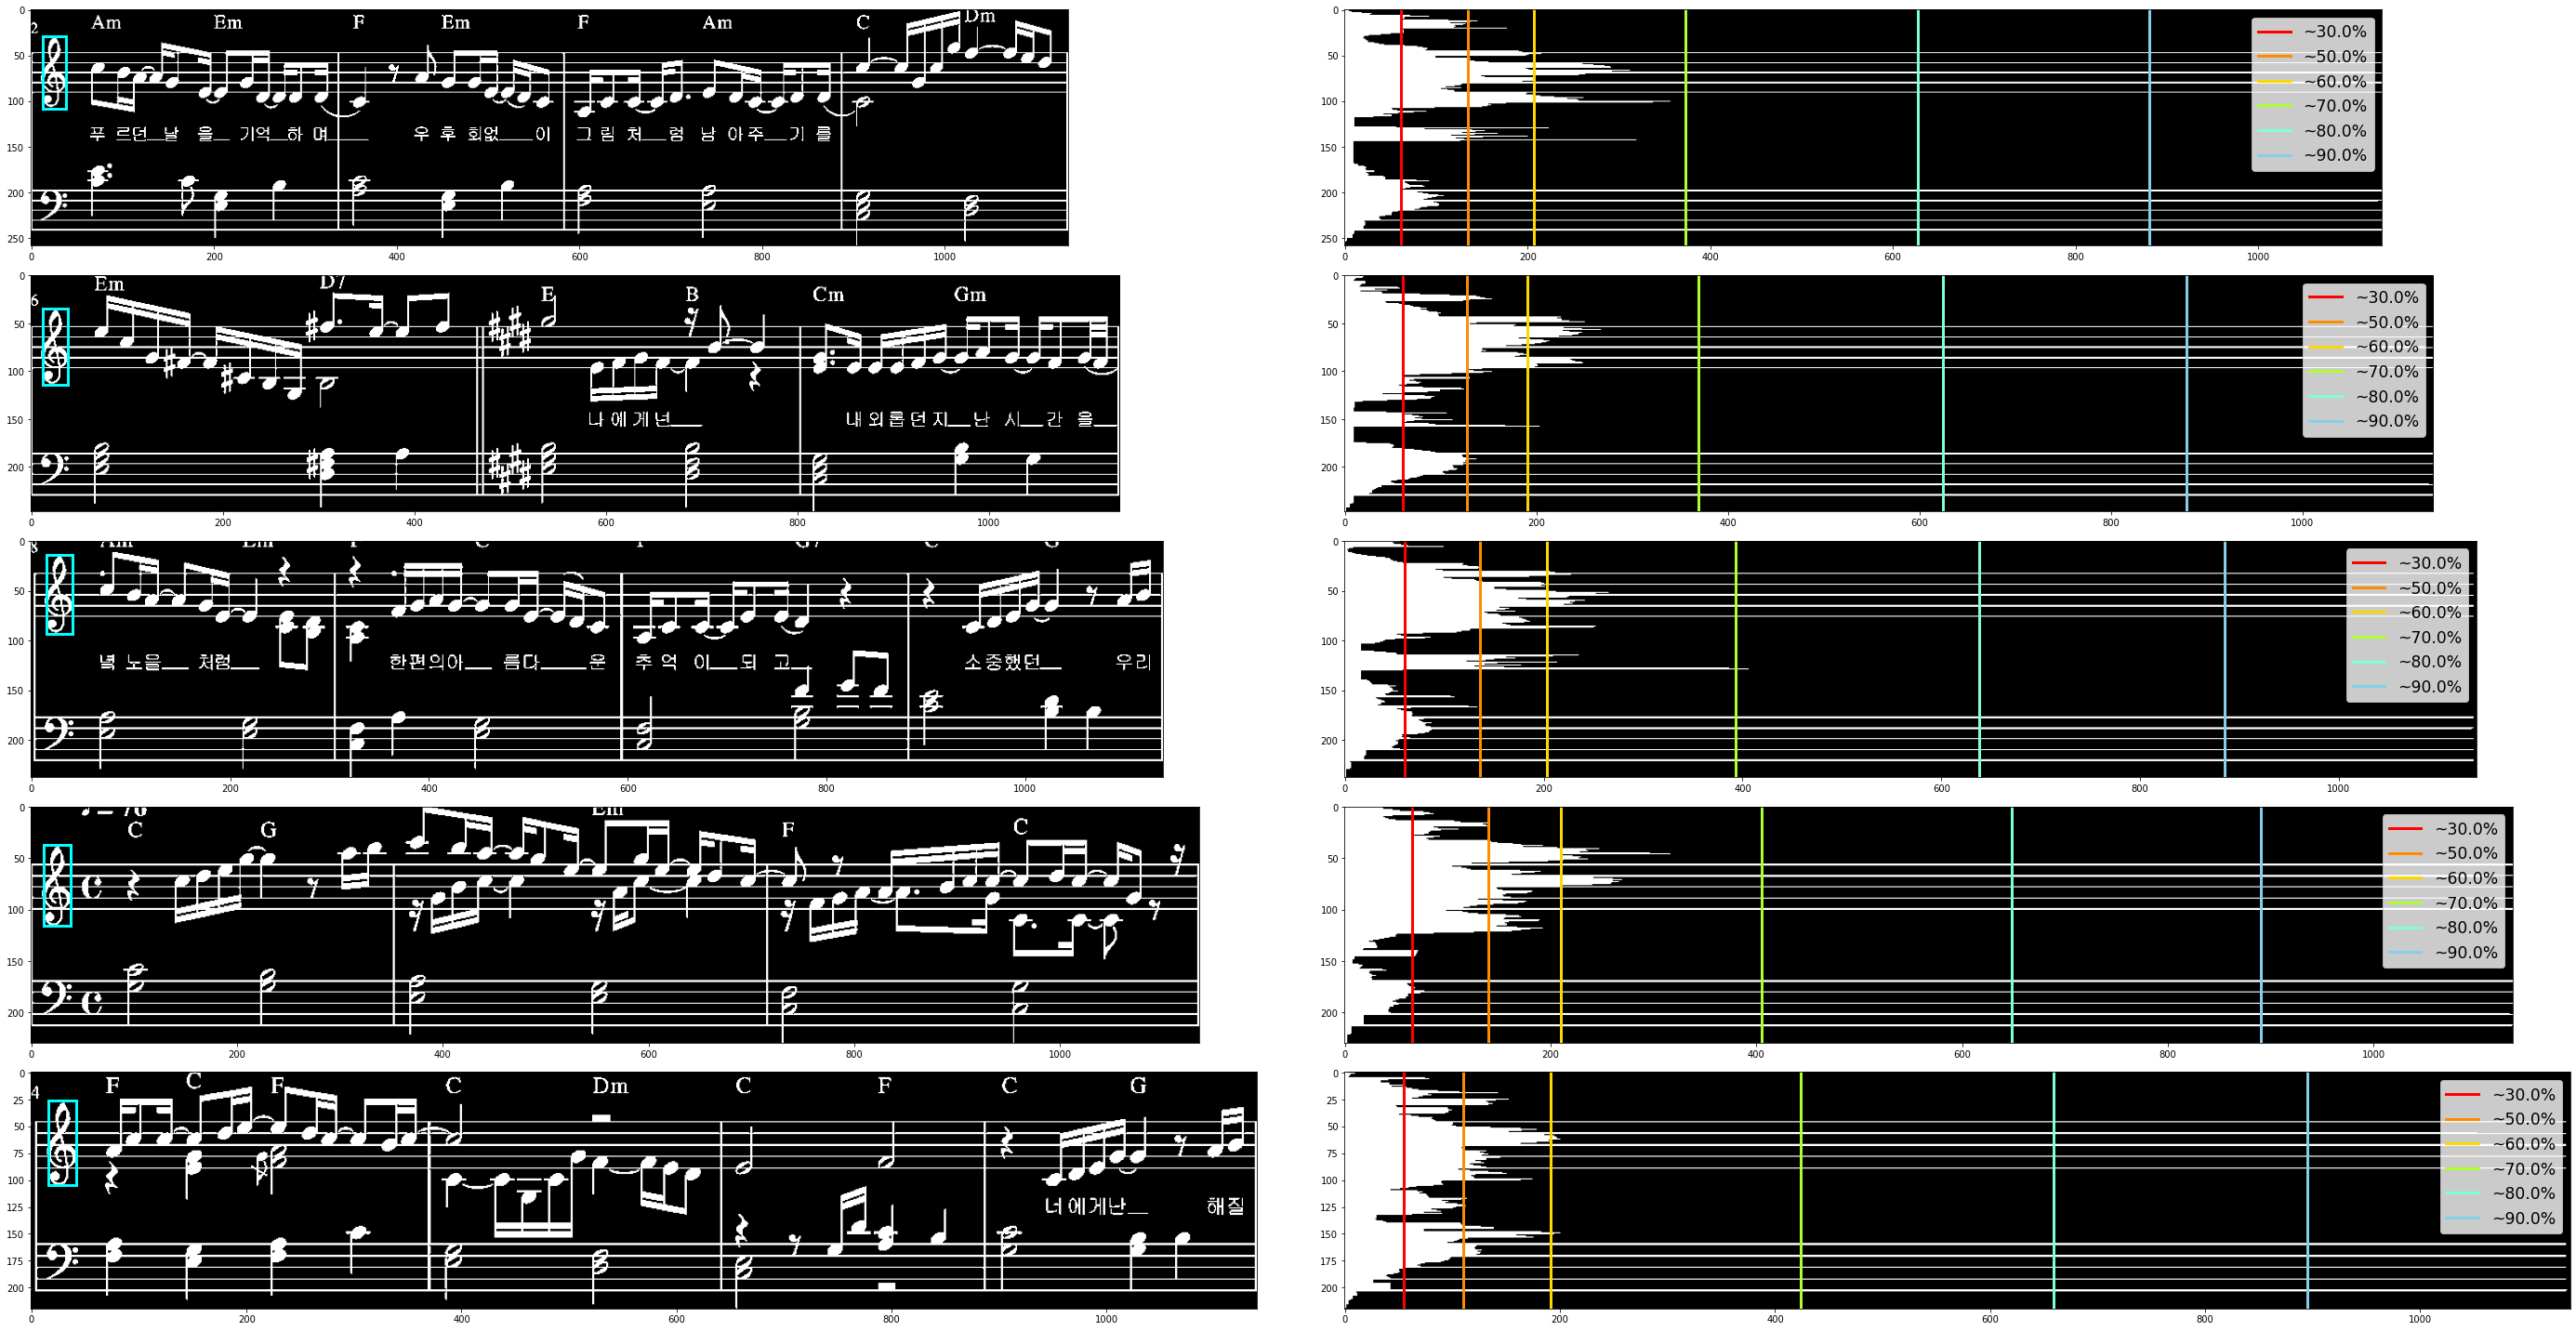

Runtime : 12.79 sec


In [15]:
ts = time.time()

component_hists = {'histogram':[], 'grid':[], 'col':[]}

row = len(main_components)
vline_opt = ['red', 'darkorange', 'gold', 'greenyellow', 'aquamarine', 'skyblue']

fig = plt.figure(figsize=(40,20))
for i, component in enumerate(main_components):
    score, scale, idx, shape, template = fs.find_best_match(component, pth.clef_imgs["treble"], np.arange(0.4, 0.9, 0.03), search_area_ratio=3)
    
    hist_image, hist_data, grid, grid_idx = fs.get_pixel_histogram(component, grid=[0.3, 0.5, 0.6, 0.7, 0.8, 0.9])
    component_hists['histogram'].append(hist_image)
    component_hists['grid'].append(grid)
    component_hists['col'].append(grid_idx)
    
    ax = plt.subplot2grid((row, 2), (i, 0))
    ax.imshow(main_components[i], cmap='gray')
    ax.add_patch(patches.Rectangle(idx[::-1], *shape[::-1], edgecolor='cyan', fill=False, linewidth=3))
    ax.set_anchor('W')
    
    ax = plt.subplot2grid((row, 2), (i, 1))
    ax.imshow(hist_image, cmap='gray')
    for j, val in enumerate(grid_idx):
        ax.axvline(x=val, color=vline_opt[j], label=f'~{100*grid[j]:.1f}%', linewidth=3)
    ax.legend(fontsize='xx-large')
    ax.set_anchor('W')

fig.set_tight_layout(True)
plt.show() 

tf = time.time()
print(f'Runtime : {tf-ts:.2f} sec')

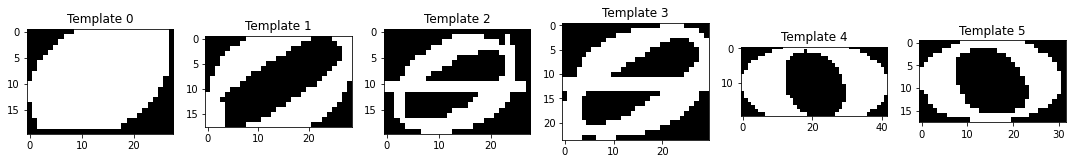

In [16]:
note_imgs = [note for note in pth.quarter_note_imgs]
note_imgs.extend(pth.half_note_imgs)
note_imgs.extend(pth.whole_note_imgs)
row = int(np.ceil(len(note_imgs)/5))

fig = plt.figure(figsize=(15, 3*row))
for i, img in enumerate(note_imgs):
    ax = fig.add_subplot(row, 6, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Template {i}')
    
fig.set_tight_layout(True)
plt.show()

In [17]:
def find_high_matches(image, templates, scales, threshold):
    if not hasattr(templates, '__iter__'):
        templates = [templates]
        
    match_info = [{'num':0, 'scale':-1, 'shape':None, 'location':None, 'score':-1} for i in range(len(templates))]

    image_height, image_width = image.shape
    for i, template_ in enumerate(templates):
        template_height, template_width = template_.shape
        for scale in scales:
            if (scale*template_width > image_width) or (scale*template_height > image_height):
                break
            template = cv2.resize(template_, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
            template_height, template_width = template.shape
            result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
            
            locations = np.where(result>threshold)
            count = len(locations[0])
            
            new_score = np.mean(result[locations]) if count != 0 else 0
            
            if match_info[i]['score'] < new_score:
                match_info[i]['num'] = count
                match_info[i]['scale'] = scale
                match_info[i]['location'] = locations
                match_info[i]['shape'] = template.shape
                match_info[i]['score'] = new_score

    return match_info


In [18]:
sample_component = main_components[3]

color_list = ['red', 'tomato', 'darkorange', 'navajowhite', 'gold', 'khaki', 'greenyellow', 'limegreen', 'aquamarine', 'aqua', 'skyblue', 'slateblue', 'blueviolet']

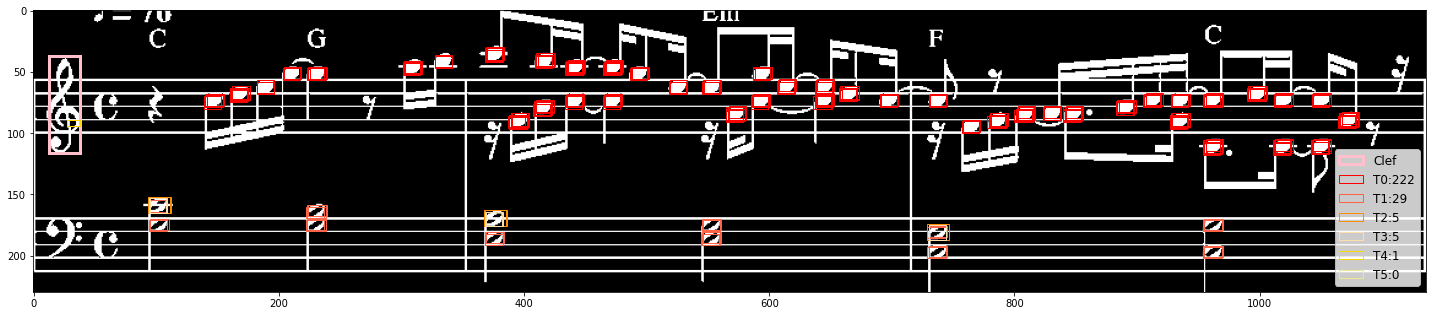

Runtime : 7.08 sec


In [19]:
ts = time.time()

fig = plt.figure(figsize=(20,40))

_, scale, clef_idx, clef_shape, _ = fs.find_best_match(sample_component, pth.clef_imgs["treble"], np.arange(0.4, 0.9, 0.03), search_area_ratio=3)
match_info = find_high_matches(sample_component, note_imgs, np.arange(max(0.2, scale-0.25), scale+0.25, 0.03)[::-1], 0.65)

ax = fig.add_subplot(1, 1, 1)
ax.imshow(sample_component, cmap='gray')
ax.add_patch(patches.Rectangle(clef_idx[::-1], *clef_shape[::-1], edgecolor='pink', fill=False, linewidth=3, label='Clef'))

for j, info in enumerate(match_info):
    ax.add_patch(patches.Rectangle((0,0), 0, 0, edgecolor=color_list[j], fill=False, label=f"T{j}:{info['num']}"))
    if info['num'] == 0: 
        continue

    shape = info['shape'][::-1]
    for k in range(info['num']):
        ax.add_patch(patches.Rectangle((info['location'][1][k], info['location'][0][k]), *shape,  edgecolor=color_list[j], fill=False))

ax.set_anchor('W')
ax.legend(fontsize='large', loc='lower right')

fig.set_tight_layout(True)
plt.show() 

tf = time.time()
print(f'Runtime : {tf-ts:.2f} sec')

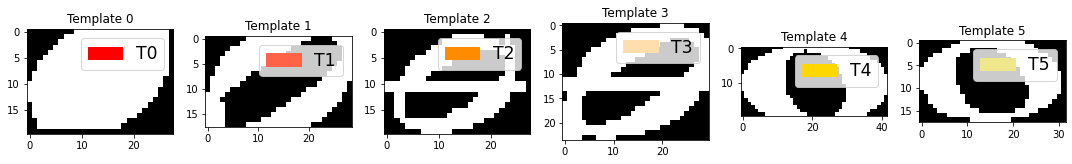

In [20]:
row = int(np.ceil(len(note_imgs)/6))

fig = plt.figure(figsize=(15, 3*row))
for i, img in enumerate(note_imgs):
    ax = fig.add_subplot(row, 6, i+1)
    ax.imshow(img, cmap='gray')
    ax.add_patch(patches.Rectangle((0,0), 0, 0, color=color_list[i], fill=True, label=f"T{i}"))
    ax.set_title(f'Template {i}')
    ax.legend(fontsize='xx-large')
    
fig.set_tight_layout(True)
plt.show()

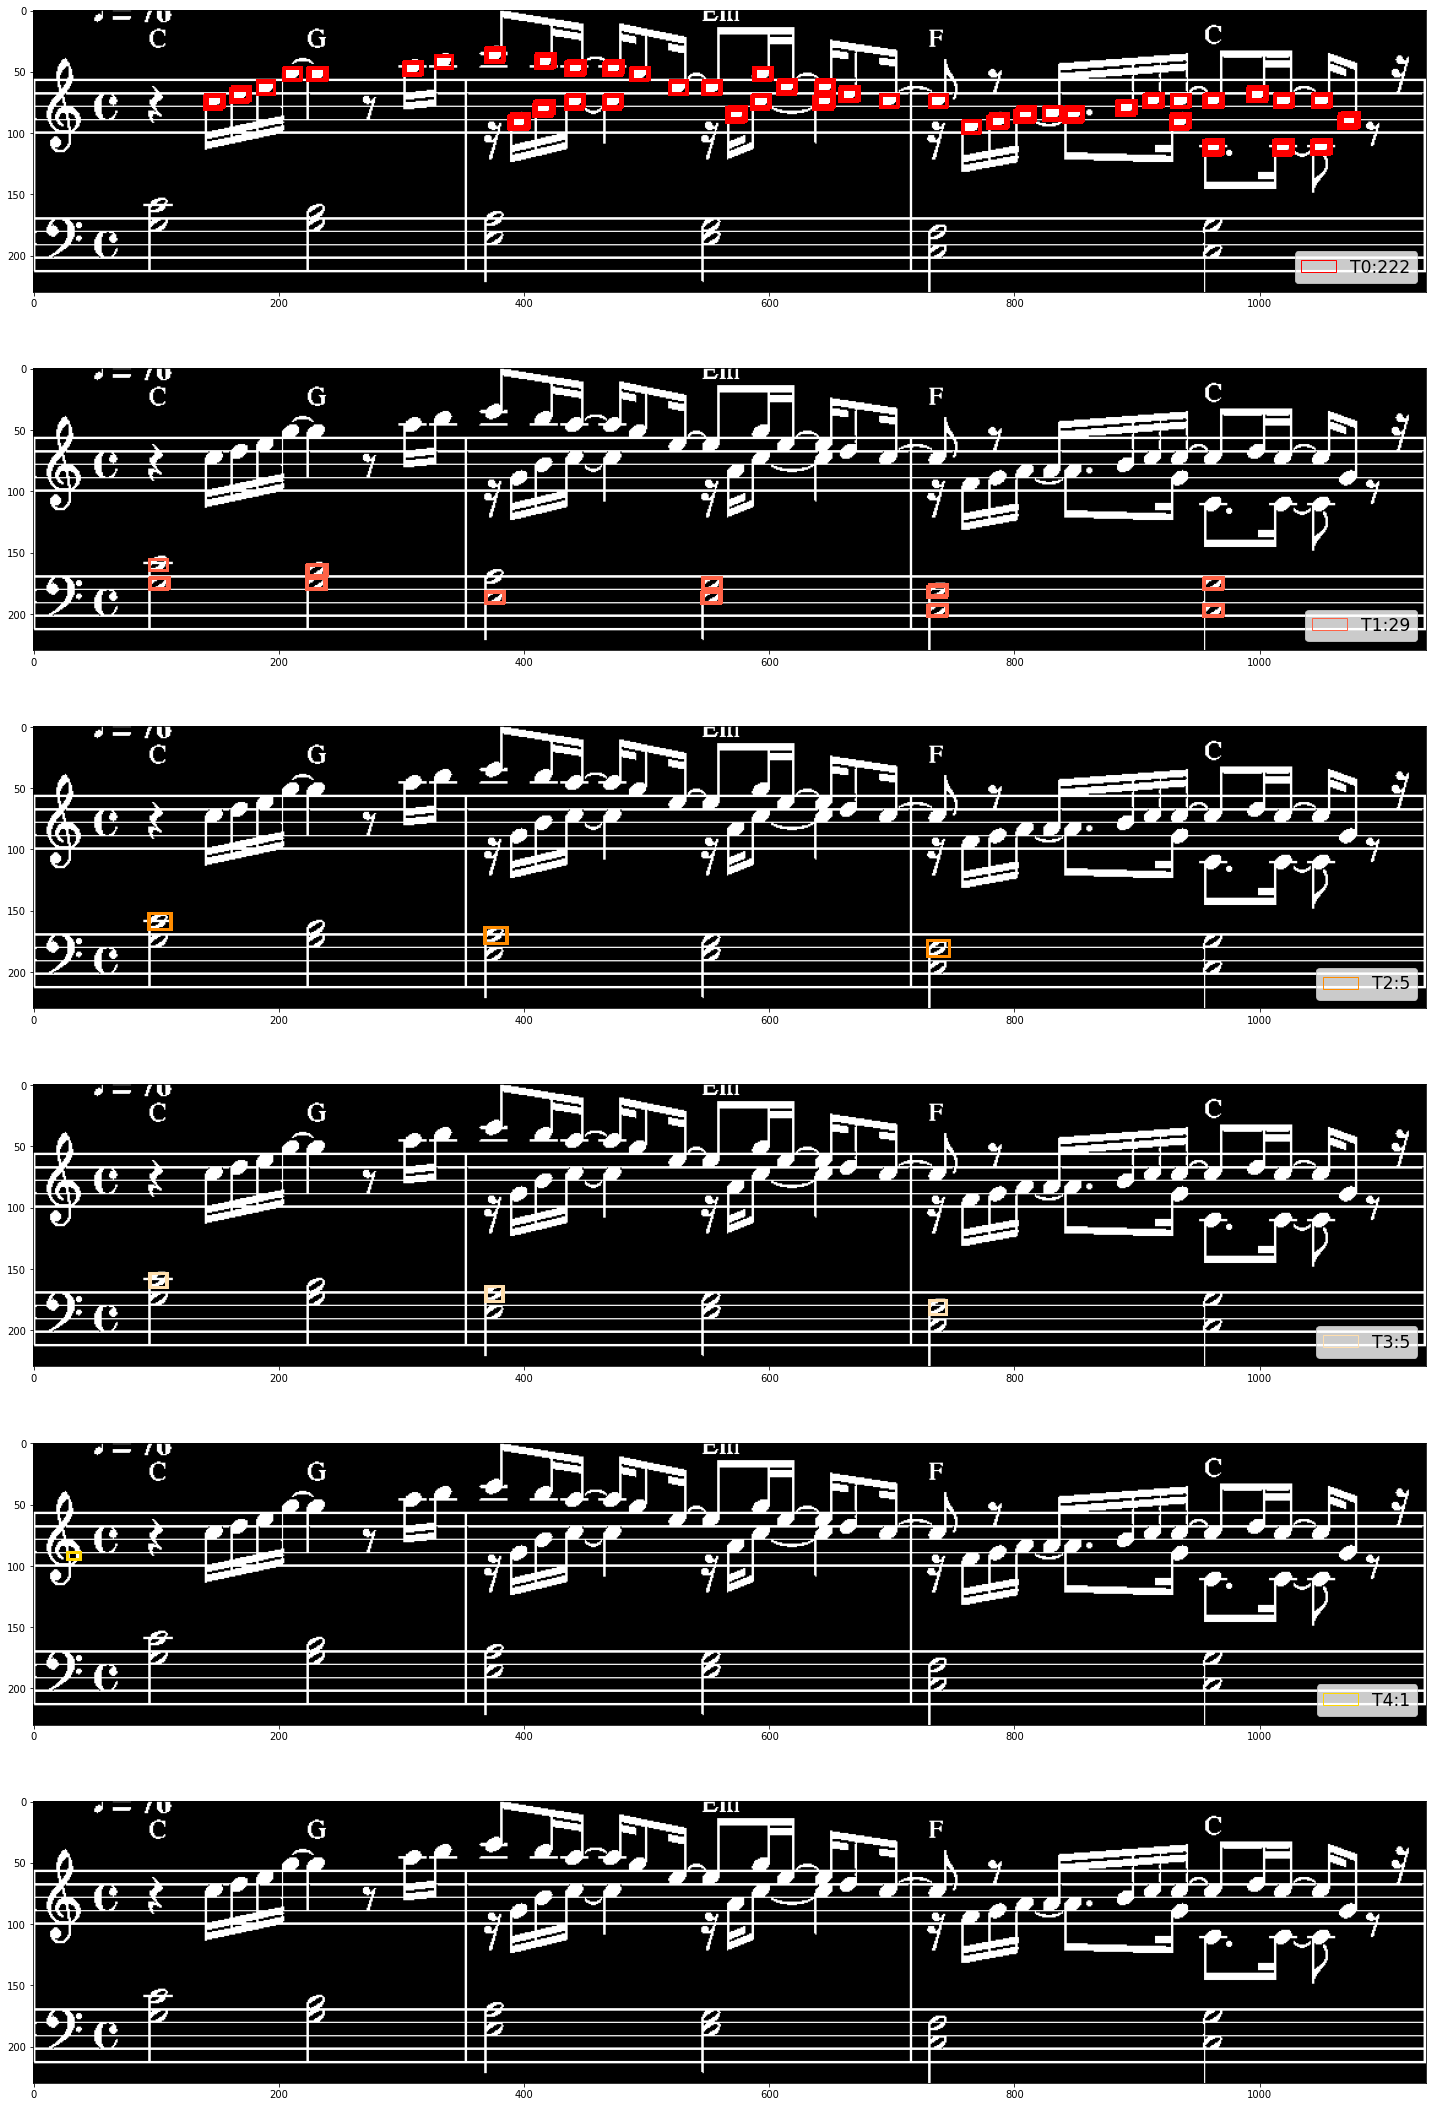

In [21]:
row = len(match_info)

fig = plt.figure(figsize=(20,row*5))

for i, info in enumerate(match_info):
    ax = fig.add_subplot(row, 1, i+1)
    ax.imshow(sample_component, cmap='gray')
    ax.add_patch(patches.Rectangle((0,0), 0, 0, edgecolor=color_list[i], fill=False, label=f"T{i}:{info['num']}"))
    if info['num'] == 0: 
        continue

    shape = info['shape'][::-1]
    for j in range(info['num']):
        ax.add_patch(patches.Rectangle((info['location'][1][j], info['location'][0][j]), *shape,  edgecolor=color_list[i], fill=False, linewidth=3))
    
    ax.legend(fontsize='xx-large', loc='lower right')
    ax.set_anchor('W')


fig.set_tight_layout(True)
plt.show() 